# Handwritten Digit Recognition

## Introduction

In this project, we use MNIST dataset that contains some grayscale handwritten digit images with size of 28x28 pixels. (28\*28 = 784 pixels)

So we have a fully connected neural network with an input layer, two hidden layers and one output layer.

* Layer0: input-layer → 784 neurons (our input is an image with 784 pixels)
* Layer1: hidden-layer-1 → 16 neurons
* Layer2: hidden-layer-2 → 16 neurons
* Layer3: output-layer → 10 neurons (our output is a number between 0 to 9)

- - - -

## 1. Reading Dataset

MNIST dataset includes training set (60k images) and test set (10k images). We use the code in [this link](https://github.com/HosseinZaredar/Computational-Intelligence/blob/main/read_MNIST.py) to implement this section.


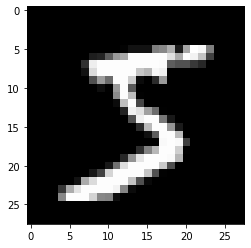

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')


# Reading The Train Set
train_images_file = open('train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)

train_set = []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    train_set.append((image, label))


# Reading The Test Set
test_images_file = open('t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_set = []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))
    
    
# Plotting an image
show_image(train_set[0][0])
plt.show()    
print(train_set[0][1])    

- - - -

## 2. Feed Forward

We use the following formula for each layer to find the values of output layer : 

$$
\begin{align}
    a^{(L+1)} = Sigmoid(w^{(L+1)}×a^{(L)}+b^{(L+1)})
\end{align}
$$

<br />

|Symbol        |Description                  | Size   |
|:-------------|:---------------------------:|:------:|
|$a^{(L+1)}$   | next layer values           |k\*1    |
|$a^{(L)}$     | current layer values        |n\*1    |
|$w^{(L+1)}$   | weights between two layers  |k\*n    |
|$b^{(L+1)}$   | next layer biases           |k\*1    |

* k = the number of neurons in next layer
* n = the number of neurons in current layer

#### Implementation of activation function:

$$
\begin{align}
    Sigmoid(x) = \frac{1}{1+e^{-x}}
\end{align}
$$

$$
\begin{align}
    Sigmoid'(x) = Sigmoid(x)×(1-Sigmoid(x))
\end{align}
$$

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

#### Initializing W matrices and b vectors & Calculating output values for first 100 images :

In [17]:
# initialize W matrices with normalize random values
W_layer1 = np.random.normal(size=(16, 784))
W_layer2 = np.random.normal(size=(16, 16))
W_layer3 = np.random.normal(size=(10, 16))

# initialize b vectors with zero values
b_layer1 = np.zeros((16, 1))
b_layer2 = np.zeros((16, 1))
b_layer3 = np.zeros((10, 1))

# calculate output values for 100 first images
train_set_size = 100
cnt_correct = 0
for i in range(0, train_set_size):

    a_layer0 = train_set[i][0]
    label = train_set[i][1]
    
    # find values of hidden layer 1
    Z1 = np.dot(W_layer1, a_layer0) + b_layer1
    a_layer1 = sigmoid(Z1)
           
    # find values of hidden layer 2
    Z2 = np.dot(W_layer2, a_layer1) + b_layer2
    a_layer2 = sigmoid(Z2)
        
    # find values of output layer
    Z3 = np.dot(W_layer3, a_layer2) + b_layer3
    a_layer3 = sigmoid(Z3)
        
    max_value_a_layer3 = a_layer3.max()
    output = np.zeros((10, 1))
    for j in range(0, 10):
        if(a_layer3[j] == max_value_a_layer3):
            output[j] = 1
    
    if((output == label).all()):
        cnt_correct += 1


#### Calculating accuracy: 
{Accuracy should be around 10% at this point!}

In [18]:
# calculate accuracy
accuracy = cnt_correct / train_set_size
print("Accuracy =", accuracy)

Accuracy = 0.11


- - - -

## 3. Backpropagation

We can train our model with minimzing cost function and finding proper weights. The most used algorithm to train neural networks is "Gradient Descent".
In this algorithm, we calculate the partial derivatives of the cost function with respect to the parameters of each layer (with chain rule).

$$
\begin{align}
    Cost = \sum_{j=0}^{n_L-1}(a_j^{(L)}-y_j)^2
\end{align}
$$

$$
\begin{align}
    (W, b)_{new} = (W, b)_{previous} - αΔCost
\end{align}
$$

<br />

In this project we use "Stochastic Gradient Descent" algorithm:

```
Pseudocode: 

Allocate W matrix and vector b for each layer
Initialize W from standard normal distribution, and b=0, for each layer
Set learning_rate, number_of_epochs and batch_size
for i from 0 to number_of_epochs:
    Shuffle the train set
    for each batch in train set:
        Allocate grad_W matrix and grad_b vector for each layer and initialize to 0
        for each image in batch:
            Compute the output for this image
            grad_W += dcost/dW for each layer
            grad_b += dcost/db for each layer
        W = W - (learning_rate × (grad_W / batch_size))
        b = b - (learning_rate × (grad_b / batch_size))

```


#### Implementation:

In [19]:
%%time

# initialize W matrices with normalize random values
W_layer1 = np.random.normal(size=(16, 784))
W_layer2 = np.random.normal(size=(16, 16))
W_layer3 = np.random.normal(size=(10, 16))

# initialize b vectors with zero values
b_layer1 = np.zeros((16, 1))
b_layer2 = np.zeros((16, 1))
b_layer3 = np.zeros((10, 1))

# set hyperparameters
number_of_epochs = 20
learning_rate = 1
batch_size = 10

train_set_size = 100
number_of_batches = int(train_set_size / batch_size) 

# values of x_axis and y_axis in cost-epoch plot
epochs = []
avg_costs_per_epoch = []

for i_epoch in range(0, number_of_epochs):
    
    all_costs = []
    
    for i_batch in range(0, number_of_batches):
        
        batch = train_set[batch_size*i_batch : batch_size*(i_batch+1)]
        
        grad_W_layer1 = np.zeros((16, 784))
        grad_W_layer2 = np.zeros((16, 16))
        grad_W_layer3 = np.zeros((10, 16))
        
        grad_b_layer1 = np.zeros((16, 1))
        grad_b_layer2 = np.zeros((16, 1))
        grad_b_layer3 = np.zeros((10, 1))
        
        for i_image in range(0, batch_size):
            
            image = batch[i_image][0]
            label = batch[i_image][1]

            # compute the output for current image
            
            a_layer0 = image
            # find values of hidden layer 1
            Z1 = np.dot(W_layer1, a_layer0) + b_layer1
            a_layer1 = sigmoid(Z1)
            # find values of hidden layer 2
            Z2 = np.dot(W_layer2, a_layer1) + b_layer2
            a_layer2 = sigmoid(Z2)
            # find values of output layer
            Z3 = np.dot(W_layer3, a_layer2) + b_layer3
            a_layer3 = sigmoid(Z3)
            
            # calculate cost function -> cost = Σ{(a_layer3 - y)^2}
            cost = 0
            for i in range(0, 10):
                a = a_layer3[i]
                y = label[i]
                cost += (a - y)**2
                
            
            # update grad_W and grad_b for each layer
            
            # backpropagation -> from last layer (layer_3) to first layer (layer_0)
            # j -> current_layer
            # k -> previous_layer
 
            # for layer3
            all_partial_derivative_cost_a2 = np.zeros((16, 1))
            for j in range(0, 10):              
                for k in range(0, 16):
                    
                    partial_derivative_cost_a3 = 2*(a_layer3[j] - label[j])
                    partial_derivative_a3_Z = sigmoid_derivative(Z3[j])
                    partial_derivative_Z_W = a_layer2[k]
                    partial_derivative_Z_b = 1
                    partial_derivative_Z_a2 = W_layer3[j][k]
                    
                    # chain rule -> update W
                    partial_derivative_cost_W = partial_derivative_cost_a3 * partial_derivative_a3_Z * partial_derivative_Z_W                  
                    grad_W_layer3[j][k] += partial_derivative_cost_W
                    
                    # calculate partial derivative of cost with respect to a2 (find partial_derivative_cost_a2)
                    all_partial_derivative_cost_a2[k, 0] += partial_derivative_cost_a3 * partial_derivative_a3_Z * partial_derivative_Z_a2
                    
                # chain rule -> update b
                partial_derivative_cost_b = partial_derivative_cost_a3 * partial_derivative_a3_Z * partial_derivative_Z_b
                grad_b_layer3[j, 0] += partial_derivative_cost_b
                
                    
            # for layer2
            all_partial_derivative_cost_a1 = np.zeros((16, 1))
            for j in range(0, 16):  
                for k in range(0, 16):
                    
                    partial_derivative_cost_a2 = all_partial_derivative_cost_a2[j]
                    partial_derivative_a2_Z = sigmoid_derivative(Z2[j])
                    partial_derivative_Z_W = a_layer1[k]
                    partial_derivative_Z_b = 1
                    partial_derivative_Z_a1 = W_layer2[j][k]
                    
                    # chain rule -> update W
                    partial_derivative_cost_W = partial_derivative_cost_a2 * partial_derivative_a2_Z * partial_derivative_Z_W
                    grad_W_layer2[j, k] += partial_derivative_cost_W
                    
                    # calculate partial derivative of cost with respect to a1 (find partial_derivative_cost_a1)
                    all_partial_derivative_cost_a1[k, 0] += partial_derivative_cost_a2 * partial_derivative_a2_Z * partial_derivative_Z_a1
                    
                # chain rule -> update b
                partial_derivative_cost_b = partial_derivative_cost_a2 * partial_derivative_a2_Z * partial_derivative_Z_b
                grad_b_layer2[j, 0] += partial_derivative_cost_b
                
 
            # for layer1
            for j in range(0, 16):
                for k in range(0, 784):
                    
                    partial_derivative_cost_a1 = all_partial_derivative_cost_a1[j]
                    partial_derivative_a_Z = sigmoid_derivative(Z1[j])
                    partial_derivative_Z_W = a_layer0[k]
                    partial_derivative_Z_b = 1
                    
                    # chain rule -> update W
                    partial_derivative_cost_W = partial_derivative_cost_a1 * partial_derivative_a_Z * partial_derivative_Z_W
                    grad_W_layer1[j, k] += partial_derivative_cost_W
                    
                # chain rule -> update b
                partial_derivative_cost_b = partial_derivative_cost_a1 * partial_derivative_a_Z * partial_derivative_Z_b
                grad_b_layer1[j, 0] += partial_derivative_cost_b    
                
    

        W_layer1 = W_layer1 - (learning_rate * (grad_W_layer1 / batch_size))
        W_layer2 = W_layer2 - (learning_rate * (grad_W_layer2 / batch_size))
        W_layer3 = W_layer3 - (learning_rate * (grad_W_layer3 / batch_size))
        
        b_layer1 = b_layer1 - (learning_rate * (grad_b_layer1 / batch_size))
        b_layer2 = b_layer2 - (learning_rate * (grad_b_layer2 / batch_size))
        b_layer3 = b_layer3 - (learning_rate * (grad_b_layer3 / batch_size))
        
        
        # calculate cost for images in this batch
        for i_image in range(0, batch_size):
            
            image = batch[i_image][0]
            label = batch[i_image][1]
        
            a_layer0 = image
            output_label = label
            # find values of hidden layer 1
            Z1 = np.dot(W_layer1, a_layer0) + b_layer1
            a_layer1 = sigmoid(Z1)
            # find values of hidden layer 2
            Z2 = np.dot(W_layer2, a_layer1) + b_layer2
            a_layer2 = sigmoid(Z2)
            # find values of output layer
            Z3 = np.dot(W_layer3, a_layer2) + b_layer3
            a_layer3 = sigmoid(Z3)

            # calculate cost -> cost = Σ{(a_layer3 - y)^2}
            cost = 0
            for i in range(0, 10):
                a = a_layer3[i]
                y = label[i]
                cost += (a - y)**2
            all_costs.append(cost) 

    # find average of costs in this epoch
    sum = 0
    for i in range(0, train_set_size):
        sum += all_costs[i]
    avg_cost = sum / train_set_size
    avg_costs_per_epoch.append(avg_cost) # y_axis
    epochs.append(i_epoch) # x_axis   
    

Wall time: 8min 56s


#### Calculating accuracy: 
{Accuracy should be between 25% and 50% at this point!}

In [20]:
# calculate output values for 100 first images
cnt_correct = 0
for i in range(0, train_set_size):

    a_layer0 = train_set[i][0]
    label = train_set[i][1]
    
    # find values of hidden layer 1
    Z1 = np.dot(W_layer1, a_layer0) + b_layer1
    a_layer1 = sigmoid(Z1)
    
    # find values of hidden layer 2
    Z2 = np.dot(W_layer2, a_layer1) + b_layer2
    a_layer2 = sigmoid(Z2)
        
    # find values of output layer
    Z3 = np.dot(W_layer3, a_layer2) + b_layer3
    a_layer3 = sigmoid(Z3)
        
    max_value_a_layer3 = a_layer3.max()
    output = np.zeros((10, 1))
    for j in range(0, 10):
        if(a_layer3[j] == max_value_a_layer3):
            output[j] = 1
    
    if((output == label).all()):
        cnt_correct += 1
        
# calculate accuracy
accuracy = cnt_correct / train_set_size
print("Accuracy =", accuracy)    

Accuracy = 0.49


#### Showing the plot of cost over training epoch (model loss plot):

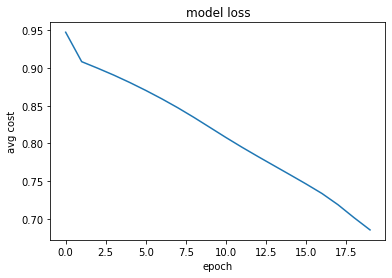

In [21]:
# show cost-epoch plot
plt.plot(epochs, avg_costs_per_epoch)
plt.xlabel('epoch')
plt.ylabel('avg cost')
plt.title('model loss')
plt.show()

- - - - 

## 4. Vectorization

By using vectorization, we can increase the speed of calculations and reduce the code execution time significantly.
In the second section, we vectorized the feedforward and now we implement the vectorized backpropagation.

$$
\begin{align}
    Vectorized Cost = (\vec{a}-\vec{y})^T(\vec{a}-\vec{y})
\end{align}
$$

<br />

In [22]:
%%time

# initialize W matrices with normalize random values
W_layer1 = np.random.normal(size=(16, 784))
W_layer2 = np.random.normal(size=(16, 16))
W_layer3 = np.random.normal(size=(10, 16))

# initialize b vectors with zero values
b_layer1 = np.zeros((16, 1))
b_layer2 = np.zeros((16, 1))
b_layer3 = np.zeros((10, 1))

# set hyperparameters
number_of_epochs = 200
learning_rate = 1
batch_size = 10

train_set_size = 100
number_of_batches = int(train_set_size / batch_size) 

# values of x_axis and y_axis in cost-epoch plot
epochs = []
avg_costs_per_epoch = []

for i_epoch in range(0, number_of_epochs):
    
    all_costs = []
    
    for i_batch in range(0, number_of_batches):

        batch = train_set[batch_size*i_batch : batch_size*(i_batch+1)]
        
        grad_W_layer1 = np.zeros((16, 784))
        grad_W_layer2 = np.zeros((16, 16))
        grad_W_layer3 = np.zeros((10, 16))
        
        grad_b_layer1 = np.zeros((16, 1))
        grad_b_layer2 = np.zeros((16, 1))
        grad_b_layer3 = np.zeros((10, 1))
        
        for i_image in range(0, batch_size):
            
            image = batch[i_image][0]
            label = batch[i_image][1]
            
            # compute the output for current image
            
            a_layer0 = image
            # find values of hidden layer 1
            Z1 = np.dot(W_layer1, a_layer0) + b_layer1
            a_layer1 = sigmoid(Z1)
            # find values of hidden layer 2
            Z2 = np.dot(W_layer2, a_layer1) + b_layer2
            a_layer2 = sigmoid(Z2)
            # find values of output layer
            Z3 = np.dot(W_layer3, a_layer2) + b_layer3
            a_layer3 = sigmoid(Z3)
            
            # calculate cost function -> cost = Transpose(a_layer3 - y) @ (a_layer3 - y)
            cost = np.transpose(a_layer3 - label) @ (a_layer3 - label)
                
                
            # update grad_W and grad_b for each layer
            
            # backpropagation -> from last layer (layer_3) to first layer (layer_0)
            # j -> current_layer
            # k -> previous_layer
 
            # for layer3

            # chain rule -> update W
            partial_derivative_cost_W = (2 * (a_layer3 - label) * sigmoid_derivative(Z3)) @ np.transpose(a_layer2)
            grad_W_layer3 += partial_derivative_cost_W
            
            # chain rule -> update b
            partial_derivative_cost_b = 2 * (a_layer3 - label) * sigmoid_derivative(Z3)
            grad_b_layer3 += partial_derivative_cost_b
                
            # calculate partial derivative of cost with respect to a2 (find partial_derivative_cost_a2)
            partial_derivative_cost_a2 = np.transpose(W_layer3) @ (2 * (a_layer3 - label) * sigmoid_derivative(Z3))
            
                
            # for layer2

            # chain rule -> update W
            partial_derivative_cost_W = (partial_derivative_cost_a2 * sigmoid_derivative(Z2)) @ np.transpose(a_layer1)
            grad_W_layer2 += partial_derivative_cost_W
            
            # chain rule -> update b
            partial_derivative_cost_b = partial_derivative_cost_a2 * sigmoid_derivative(Z2)
            grad_b_layer2 += partial_derivative_cost_b
                
            # calculate partial derivative of cost with respect to a1 (find partial_derivative_cost_a1)
            partial_derivative_cost_a1 = np.transpose(W_layer2) @ (partial_derivative_cost_a2 * sigmoid_derivative(Z2))    
                
                
            # for layer1

            # chain rule -> update W
            partial_derivative_cost_W = (partial_derivative_cost_a1 * sigmoid_derivative(Z1)) @ np.transpose(a_layer0)
            grad_W_layer1 += partial_derivative_cost_W
            
            # chain rule -> update b
            partial_derivative_cost_b = partial_derivative_cost_a1 * sigmoid_derivative(Z1)
            grad_b_layer1 += partial_derivative_cost_b
                   
                
        W_layer1 = W_layer1 - (learning_rate * (grad_W_layer1 / batch_size))
        W_layer2 = W_layer2 - (learning_rate * (grad_W_layer2 / batch_size))
        W_layer3 = W_layer3 - (learning_rate * (grad_W_layer3 / batch_size))
        
        b_layer1 = b_layer1 - (learning_rate * (grad_b_layer1 / batch_size))
        b_layer2 = b_layer2 - (learning_rate * (grad_b_layer2 / batch_size))
        b_layer3 = b_layer3 - (learning_rate * (grad_b_layer3 / batch_size))
        
        
        # calculate cost for images in this batch
        for i_image in range(0, batch_size):
            
            image = batch[i_image][0]
            label = batch[i_image][1]
        
            a_layer0 = image
            output_label = label
            # find values of hidden layer 1
            Z1 = np.dot(W_layer1, a_layer0) + b_layer1
            a_layer1 = sigmoid(Z1)
            # find values of hidden layer 2
            Z2 = np.dot(W_layer2, a_layer1) + b_layer2
            a_layer2 = sigmoid(Z2)
            # find values of output layer
            Z3 = np.dot(W_layer3, a_layer2) + b_layer3
            a_layer3 = sigmoid(Z3)

            # calculate cost -> cost = Transpose(a_layer3 - y) @ (a_layer3 - y)
            cost = np.transpose(a_layer3 - label) @ (a_layer3 - label)
            all_costs.append(cost[0]) 

    # find average of costs in this epoch
    sum = 0
    for i in range(0, train_set_size):
        sum += all_costs[i]
    avg_cost = sum / train_set_size
    avg_costs_per_epoch.append(avg_cost) # y_axis
    epochs.append(i_epoch) # x_axis   

Wall time: 18.3 s


#### Calculating accuracy: 

In [23]:
# calculate output values for 100 first images
cnt_correct = 0
for i in range(0, train_set_size):

    a_layer0 = train_set[i][0]
    label = train_set[i][1]
    
    # find values of hidden layer 1
    Z1 = np.dot(W_layer1, a_layer0) + b_layer1
    a_layer1 = sigmoid(Z1)
    
    # find values of hidden layer 2
    Z2 = np.dot(W_layer2, a_layer1) + b_layer2
    a_layer2 = sigmoid(Z2)
        
    # find values of output layer
    Z3 = np.dot(W_layer3, a_layer2) + b_layer3
    a_layer3 = sigmoid(Z3)
        
    max_value_a_layer3 = a_layer3.max()
    output = np.zeros((10, 1))
    for j in range(0, 10):
        if(a_layer3[j] == max_value_a_layer3):
            output[j] = 1
    
    if((output == label).all()):
        cnt_correct += 1
        
# calculate accuracy
accuracy = cnt_correct / train_set_size
print("Accuracy =", accuracy)    

Accuracy = 0.98


#### Showing the plot of cost over training epoch (model loss plot):

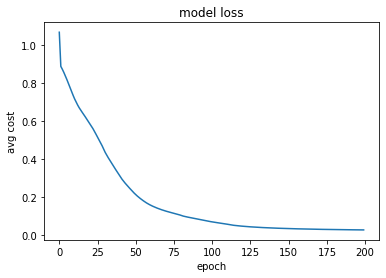

In [24]:
# show cost-epoch plot
plt.plot(epochs, avg_costs_per_epoch)
plt.xlabel('epoch')
plt.ylabel('avg cost')
plt.title('model loss')
plt.show()

- - - - 

## 5. Testing 

In this section instead of using the first 100 images, we use the entire train_set data (60k images) to train our neural network. After that, we test the model with test_set data (10k images).


In [25]:
%%time

# initialize W matrices with normalize random values
W_layer1 = np.random.normal(size=(16, 784))
W_layer2 = np.random.normal(size=(16, 16))
W_layer3 = np.random.normal(size=(10, 16))

# initialize b vectors with zero values
b_layer1 = np.zeros((16, 1))
b_layer2 = np.zeros((16, 1))
b_layer3 = np.zeros((10, 1))

# set hyperparameters
number_of_epochs = 5
learning_rate = 1
batch_size = 50

# change train_set_size -> train all data in train_set
train_set_size = len(train_set)
number_of_batches = int(train_set_size / batch_size) 

# values of x_axis and y_axis in cost-epoch plot
epochs = []
avg_costs_per_epoch = []

for i_epoch in range(0, number_of_epochs):
    
    all_costs = []
    
    for i_batch in range(0, number_of_batches):

        batch = train_set[batch_size*i_batch : batch_size*(i_batch+1)]
        
        grad_W_layer1 = np.zeros((16, 784))
        grad_W_layer2 = np.zeros((16, 16))
        grad_W_layer3 = np.zeros((10, 16))
        
        grad_b_layer1 = np.zeros((16, 1))
        grad_b_layer2 = np.zeros((16, 1))
        grad_b_layer3 = np.zeros((10, 1))
        
        for i_image in range(0, batch_size):
            
            image = batch[i_image][0]
            label = batch[i_image][1]
            
            # compute the output for current image
            
            a_layer0 = image
            # find values of hidden layer 1
            Z1 = np.dot(W_layer1, a_layer0) + b_layer1
            a_layer1 = sigmoid(Z1)
            # find values of hidden layer 2
            Z2 = np.dot(W_layer2, a_layer1) + b_layer2
            a_layer2 = sigmoid(Z2)
            # find values of output layer
            Z3 = np.dot(W_layer3, a_layer2) + b_layer3
            a_layer3 = sigmoid(Z3)
            
            # calculate cost function -> cost = Transpose(a_layer3 - y) @ (a_layer3 - y)
            cost = np.transpose(a_layer3 - label) @ (a_layer3 - label)
                
                
            # update grad_W and grad_b for each layer
            
            # backpropagation -> from last layer (layer_3) to first layer (layer_0)
            # j -> current_layer
            # k -> previous_layer
 
            # for layer3

            # chain rule -> update W
            partial_derivative_cost_W = (2 * (a_layer3 - label) * sigmoid_derivative(Z3)) @ np.transpose(a_layer2)
            grad_W_layer3 += partial_derivative_cost_W
            
            # chain rule -> update b
            partial_derivative_cost_b = 2 * (a_layer3 - label) * sigmoid_derivative(Z3)
            grad_b_layer3 += partial_derivative_cost_b
                
            # calculate partial derivative of cost with respect to a2 (find partial_derivative_cost_a2)
            partial_derivative_cost_a2 = np.transpose(W_layer3) @ (2 * (a_layer3 - label) * sigmoid_derivative(Z3))
            
                
            # for layer2

            # chain rule -> update W
            partial_derivative_cost_W = (partial_derivative_cost_a2 * sigmoid_derivative(Z2)) @ np.transpose(a_layer1)
            grad_W_layer2 += partial_derivative_cost_W
            
            # chain rule -> update b
            partial_derivative_cost_b = partial_derivative_cost_a2 * sigmoid_derivative(Z2)
            grad_b_layer2 += partial_derivative_cost_b
                
            # calculate partial derivative of cost with respect to a1 (find partial_derivative_cost_a1)
            partial_derivative_cost_a1 = np.transpose(W_layer2) @ (partial_derivative_cost_a2 * sigmoid_derivative(Z2))    
                
                
            # for layer1

            # chain rule -> update W
            partial_derivative_cost_W = (partial_derivative_cost_a1 * sigmoid_derivative(Z1)) @ np.transpose(a_layer0)
            grad_W_layer1 += partial_derivative_cost_W
            
            # chain rule -> update b
            partial_derivative_cost_b = partial_derivative_cost_a1 * sigmoid_derivative(Z1)
            grad_b_layer1 += partial_derivative_cost_b
                   
                
        W_layer1 = W_layer1 - (learning_rate * (grad_W_layer1 / batch_size))
        W_layer2 = W_layer2 - (learning_rate * (grad_W_layer2 / batch_size))
        W_layer3 = W_layer3 - (learning_rate * (grad_W_layer3 / batch_size))
        
        b_layer1 = b_layer1 - (learning_rate * (grad_b_layer1 / batch_size))
        b_layer2 = b_layer2 - (learning_rate * (grad_b_layer2 / batch_size))
        b_layer3 = b_layer3 - (learning_rate * (grad_b_layer3 / batch_size))
        
        
        # calculate cost for images in this batch
        for i_image in range(0, batch_size):
            
            image = batch[i_image][0]
            label = batch[i_image][1]
        
            a_layer0 = image
            output_label = label
            # find values of hidden layer 1
            Z1 = np.dot(W_layer1, a_layer0) + b_layer1
            a_layer1 = sigmoid(Z1)
            # find values of hidden layer 2
            Z2 = np.dot(W_layer2, a_layer1) + b_layer2
            a_layer2 = sigmoid(Z2)
            # find values of output layer
            Z3 = np.dot(W_layer3, a_layer2) + b_layer3
            a_layer3 = sigmoid(Z3)

            # calculate cost -> cost = Transpose(a_layer3 - y) @ (a_layer3 - y)
            cost = np.transpose(a_layer3 - label) @ (a_layer3 - label)
            all_costs.append(cost[0]) 

    # find average of costs in this epoch
    sum = 0
    for i in range(0, train_set_size):
        sum += all_costs[i]
    avg_cost = sum / train_set_size
    avg_costs_per_epoch.append(avg_cost) # y_axis
    epochs.append(i_epoch) # x_axis   

Wall time: 3min 29s


#### Showing the plot of cost over training epoch (model loss plot):

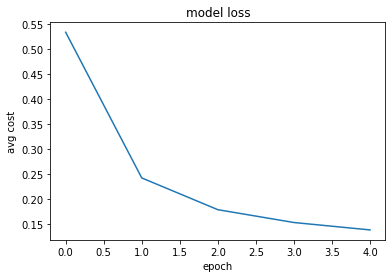

In [28]:
# showing cost-epoch plot

plt.plot(epochs, avg_costs_per_epoch)
plt.xlabel('epoch')
plt.ylabel('avg cost')
plt.title('model loss')
plt.show()

### Calculating accuracy of model:

#### I. For training data :

In [30]:
train_set_size = len(train_set)

cnt_correct = 0
for i in range(0, train_set_size):

    a_layer0 = train_set[i][0]
    label = train_set[i][1]
    
    Z1 = np.dot(W_layer1, a_layer0) + b_layer1
    a_layer1 = sigmoid(Z1)
    Z2 = np.dot(W_layer2, a_layer1) + b_layer2
    a_layer2 = sigmoid(Z2)    
    Z3 = np.dot(W_layer3, a_layer2) + b_layer3
    a_layer3 = sigmoid(Z3)
        
    max_value_a_layer3 = a_layer3.max()
    output = np.zeros((10, 1))
    for j in range(0, 10):
        if(a_layer3[j] == max_value_a_layer3):
            output[j] = 1
    
    if((output == label).all()):
        cnt_correct += 1
        
accuracy = cnt_correct / train_set_size
print("Accuracy (train set) =", accuracy) 

Accuracy (train set) = 0.9046333333333333


#### II. For testing data :

In [31]:
test_set_size = len(test_set)

cnt_correct = 0
for i in range(0, test_set_size):

    a_layer0 = test_set[i][0]
    label = test_set[i][1]
    
    Z1 = np.dot(W_layer1, a_layer0) + b_layer1
    a_layer1 = sigmoid(Z1)
    Z2 = np.dot(W_layer2, a_layer1) + b_layer2
    a_layer2 = sigmoid(Z2)    
    Z3 = np.dot(W_layer3, a_layer2) + b_layer3
    a_layer3 = sigmoid(Z3)
        
    max_value_a_layer3 = a_layer3.max()
    output = np.zeros((10, 1))
    for j in range(0, 10):
        if(a_layer3[j] == max_value_a_layer3):
            output[j] = 1
    
    if((output == label).all()):
        cnt_correct += 1
        
accuracy = cnt_correct / test_set_size
print("Accuracy (test set) =", accuracy) 

Accuracy (test set) = 0.9017
